In [ ]:
import re
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf



In [9]:


# Specify relative path to the file
file_path = "../IAPS/banco_completo.csv"
df = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1')

# Update the values
mapping = {
    1: 'branca',
    2: 'preta',
    3: 'parda',
    4: 'amarela',
    5: 'indígena',
    99: 'sem informação'
}

df['racacor'] = df['racacor'].map(mapping)

# Save the modified DataFrame as a new CSV file
output_file = 'modified_data.csv'
df.to_csv(output_file, index=False)

print(f"The modified data has been saved to {output_file}.")


The modified data has been saved to modified_data.csv.


In [10]:
# Update the values
mapping = {
    1: 'cirurgia oncológica',
    2: 'quimioterapia',
    3: 'radioterapia',
    4: 'diagnóstico',
    5: 'outros de oncologia',
    6: 'outras cirurgias com os CIDs de câncer "C" ou "D"'
}

df['tipo_proc_min'] = df['tipo_proc_min'].map(mapping)

In [45]:


# Function to check if a value looks like a date
def is_date_format(value):
    # Regular expression pattern to match date format dd/mm/yyyy
    pattern = r"\d{2}/\d{2}/\d{4}"
    if re.match(pattern, str(value)):
        return True
    return False

# Identify columns to drop based on date format or specific substrings in column name
cols_to_drop = [
    col for col in df.columns if any(df[col].apply(is_date_format)) 
    or 'ID' in col 
    or 'obito_internacao' in col 
    or 'qt_obito_simaih' in col 
    or 'causabas_simaih_rec' in col 
    or 'causabas_simaih_rec_agrup' in col 
    or 'causabas_simaih_rec_agrup2' in col
    or 'causabas' in col  # added this
]

# Drop identified columns
df.drop(columns=cols_to_drop, inplace=True)



In [46]:
print(df.loc[1])

sexo                                             M
racacor                                     branca
qt_apac                                          2
qt_aih                                           2
obito                                            1
estadio                                          4
idade                                           51
tipo_proc_min                        quimioterapia
cidpri_min                                    C342
proc_max                                 304020214
n_comorb                                         4
desc_f_org_tto_min                QUIMIO_PALIATIVA
cid_tto_min                                   C342
tipo_tto_min                                     2
tempo_diag_tto_min                              47
tempo_internacao                                 7
tempo_coorte                                     6
perfil                                          20
estadio_rec                        Doença Avançada
f_org_tto_min_rec              

In [50]:

df['cir_proc_tto_min_rec'] = df['cir_proc_tto_min_rec'].replace('CIRURGIAS MULTIPLAS E SEQUENCIAIS', 'multiplas_cir_seq')

# Convert categorical variables to one-hot encoded columns
categorical_cols =['sexo', 'racacor', 'estadio', 'tipo_proc_min', 'proc_max', 
    'desc_f_org_tto_min', 'tipo_tto_min', 'perfil', 'estadio_rec','cidpri_min', 'cid_tto_min',
    'f_org_tto_min_rec', 'perfil_rec','cir_proc_tto_min_rec', 'cir_proc_tto_min_rec2',
    'cump_lei60dias', 'macro_tto', 'mun_pcn', 'regiao_pcn', 'macro_pcn', 'estabel_saude', 'cidade_estabel',
    'estado_estabel', 'regiao_estabel', 'macro_estabel', 'regiao_bras_estabel', 'finaliquimio',
    'finaliradio', 'time_diag']  
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Convert numeric variables to the correct data type
numeric_cols = ['qt_apac', 'qt_aih', 'idade', 'n_comorb', 'tempo_diag_tto_min', 'tempo_internacao', 'tempo_coorte']  
df_encoded[numeric_cols] = df_encoded[numeric_cols].astype(float)

# Apply Z-score normalization to numeric columns
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

# Prepare the data
X = df_encoded.drop('obito', axis=1)  # Features
y = df_encoded['obito']  # Target variable




In [51]:
df_encoded

qt_apac     qt_aih  obito     idade  n_comorb  tempo_diag_tto_min  \
0    -0.859304   1.134737      1 -0.572278  0.918494           -0.586332   
1    -0.391294   0.125871      1 -1.112483  0.158465            0.093361   
2    -0.391294   3.152467      1  0.057961  0.918494           -0.542947   
3    -0.859304  -0.378562      1  1.048337  0.158465           -0.427255   
4     0.544724  -0.378562      1  0.418098 -0.981579           -0.499562   
5    -0.859304  -0.882994      1  0.778234  0.918494           -0.514024   
6     3.352779  -0.378562      0  1.228405  0.918494           -0.427255   
7    -0.859304  -0.882994      1  0.418098  0.918494           -0.282639   
8     0.544724   2.648035      1 -0.932415  0.918494           -0.586332   
9    -0.391294  -0.882994      0  0.958302  0.158465            0.310285   
10   -0.859304  -0.882994      1 -0.032073 -0.601564           -0.571870   
11   -0.859304  -0.378562      1 -0.662312 -0.221550           -0.586332   
12   -0.859304  -0.882994      1 -0.662312  0.158465            2.493980   
13    0.076715   0.630304      1  0.418098  1.298509           -0.224793   
14   -0.859304   0.125871      1  0.147995 -0.601564           -0.586332   
15   -0.859304  -0.882994      1  0.688200  0.538480            6.991523   
16   -0.391294  -0.882994      1 -0.302176 -0.221550            0.151208   
17   -0.391294   0.630304      0 -0.032073 -0.601564            0.339208   
18    0.544724  -0.378562      1 -0.482244 -1.361594           -0.586332   
19    0.076715  -0.378562      1  1.228405 -0.601564           -0.297101   
20   -0.391294   0.630304      0 -0.752346 -0.601564           -0.340485   
21    1.480742  -0.378562      0  0.508132  1.298509            0.281362   
22   -0.859304  -0.378562      1  0.238029  0.158465            0.006592   
23    0.076715  -0.882994      0  0.958302 -1.361594           -0.586332   
24    0.076715  -0.882994      1 -3.183268 -0.981579           -0.326024   
25   -0.391294  -0.378562      0 -0.302176 -0.981579            1.047824   
26   -0.391294  -0.378562      1 -0.122107 -0.601564           -0.022331   
27    0.544724  -0.378562      1 -0.032073  1.298509           -0.412793   
28   -0.859304  -0.882994      1  1.228405  1.298509           -0.080177   
29    0.076715   0.125871      0 -1.022449 -0.221550            0.122285   
30    1.948752   2.143602      0  0.778234  5.098656           -0.398331   
31   -0.859304  -0.882994      1  1.678576  0.918494           -0.007869   
32    0.076715  -0.882994      0 -0.212141 -0.221550            0.628439   
33   -0.859304  -0.882994      1  1.858644  0.158465            0.527208   
34   -0.859304  -0.378562      0  0.598166 -0.221550           -0.485101   
35   -0.391294   0.125871      0 -1.742722 -1.361594           -0.586332   
36   -0.391294  -0.378562      1  0.598166  1.298509            0.700747   
37   -0.859304  -0.378562      0  0.598166 -0.981579            0.035515   
38    1.948752   0.630304      1  0.778234  1.678524           -0.326024   
39   -0.391294   0.125871      1 -0.302176  0.538480           -0.326024   
40   -0.859304   0.630304      0 -0.572278 -0.221550            0.180131   
41    0.076715   0.125871      1 -0.392210 -0.981579           -0.166947   
42    0.076715   1.639169      1 -0.482244  0.158465           -0.586332   
43   -0.859304  -0.882994      0 -0.932415 -1.361594           -0.282639   
44   -0.859304   0.125871      1 -0.572278  0.538480           -0.586332   
45    0.076715   0.125871      1  0.147995 -0.981579            1.828748   
46   -0.859304   0.125871      1 -0.212141  0.158465           -0.326024   
47   -0.391294   0.125871      1  1.138371 -0.601564           -0.586332   
48   -0.391294  -0.882994      0  1.408473 -0.981579           -0.166947   
49    0.076715  -0.882994      1  1.588541 -0.981579           -0.282639   
50   -0.391294   0.125871      1  1.948678  1.298509           -0.354947   
51   -0.859304  -0.882994      1  0.688200 -0.221550   

In [135]:
output_file = 'banco_completo_modificado.csv'
df.to_csv(output_file, index=False)

In [127]:


# Define the parameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create a base model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

# Initialize the Grid Search model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the best score (using the 'accuracy' metric as we've specified)
print("Best accuracy found: ", grid_search.best_score_)

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Get feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns

# Print feature importances
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best accuracy found:  0.7804750717828243
qt_apac: 0.0076
qt_aih: 0.0354
idade: 0.0148
n_comorb: 0.0370
tempo_diag_tto_min: 0.0136
tempo_internacao: 0.0205
tempo_coorte: 0.0436
sexo_F: 0.0190
sexo_M: 0.0000
racacor_amarela: 0.0000
racacor_branca: 0.0108
racacor_indígena: 0.0000
racacor_parda: 0.0063
racacor_preta: 0.0117
racacor_sem informação: 0.0033
estadio_1: 0.0000
estadio_2: 0.0209
estadio_3: 0.0000
estadio_4: 0.0147
tipo_proc_min_cirurgia oncológica: 0.0054
tipo_proc_min_diagnóstico: 0.0000
tipo_proc_min_outras cirurgias com os CIDs de câncer "C" ou "D": 0.0000
tipo_proc_min_outros de oncologia: 0.0114
tipo_proc_min_quimioterapia: 0.0043
tipo_proc_min_radioterapia: 0.0156
proc_max_304010090: 0.0000
proc_max_304010103: 0.0000
proc_max_304010111: 0.0000
proc_max_304010219: 0.0000
proc_max_304010286: 0.0000
proc_max_304010294: 0.0167
proc_max_304020010: 0.0000
proc_max_304020028: 0.0000
proc_max_30402

In [130]:
LISTA=[[0 for i in range(3)] for i in range(100)]

In [131]:
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # Create XGBoost classifier
    model = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    LISTA[i][0] = accuracy_score(y_test, y_pred)


    
    # Train the logistic regression model
    model = LogisticRegression(max_iter=500)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    LISTA[i][1] = accuracy_score(y_test, y_pred)


    
    
    
    # New Neural Network Model using Keras
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile with an optimizer that has a learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Early Stopping to monitor the validation loss and stop when it starts increasing
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with validation data and early stopping
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Make predictions on the test set
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    # Evaluate the model
    LISTA[i][2] = accuracy_score(y_test, y_pred)




Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 1.1814 - accuracy: 0.6920 - val_loss: 0.8044 - val_accuracy: 0.6942
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.7156 - accuracy: 0.7408 - val_loss: 0.6599 - val_accuracy: 0.7537
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6273 - accuracy: 0.7489 - val_loss: 0.6172 - val_accuracy: 0.7505
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5902 - accuracy: 0.7554 - val_loss: 0.6011 - val_accuracy: 0.7390
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5762 - accuracy: 0.7614 - val_loss: 0.5883 - val_accuracy: 0.7380
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5715 - accuracy: 0.7585 - val_loss: 0.5806 - val_accuracy: 0.7578
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5629 - accuracy: 0.7627 - val_loss: 0.5781 - val_accuracy: 0.7463
Epoch 

120/120 [==============================] - 0s 2ms/step - loss: 0.5589 - accuracy: 0.7570 - val_loss: 0.5368 - val_accuracy: 0.7672
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5626 - accuracy: 0.7539 - val_loss: 0.5232 - val_accuracy: 0.7777
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5595 - accuracy: 0.7531 - val_loss: 0.5369 - val_accuracy: 0.7651
Epoch 13/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5642 - accuracy: 0.7515 - val_loss: 0.5246 - val_accuracy: 0.7787
Epoch 14/50
30/30 [==============================] - 0s 809us/step
Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 1.1918 - accuracy: 0.6753 - val_loss: 0.7886 - val_accuracy: 0.6962
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.7294 - accuracy: 0.7110 - val_loss: 0.6376 - val_accuracy: 0.7568
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6355 - accura

120/120 [==============================] - 0s 2ms/step - loss: 0.5713 - accuracy: 0.7567 - val_loss: 0.5673 - val_accuracy: 0.7526
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5576 - accuracy: 0.7570 - val_loss: 0.5619 - val_accuracy: 0.7578
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5599 - accuracy: 0.7541 - val_loss: 0.5658 - val_accuracy: 0.7505
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5612 - accuracy: 0.7596 - val_loss: 0.5618 - val_accuracy: 0.7505
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5553 - accuracy: 0.7549 - val_loss: 0.5582 - val_accuracy: 0.7662
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5559 - accuracy: 0.7578 - val_loss: 0.5559 - val_accuracy: 0.7599
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5520 - accuracy: 0.7617 - val_loss: 0.5525 - val_accuracy: 0.7651
Epoch 13/50
12

120/120 [==============================] - 0s 2ms/step - loss: 0.5515 - accuracy: 0.7677 - val_loss: 0.5613 - val_accuracy: 0.7463
Epoch 16/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5519 - accuracy: 0.7693 - val_loss: 0.5618 - val_accuracy: 0.7526
Epoch 17/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5454 - accuracy: 0.7685 - val_loss: 0.5642 - val_accuracy: 0.7516
Epoch 18/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5469 - accuracy: 0.7661 - val_loss: 0.5607 - val_accuracy: 0.7651
Epoch 19/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5452 - accuracy: 0.7708 - val_loss: 0.5619 - val_accuracy: 0.7547
Epoch 20/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5463 - accuracy: 0.7739 - val_loss: 0.5638 - val_accuracy: 0.7505
Epoch 21/50
30/30 [==============================] - 0s 751us/step
Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 1.1863 - accu

120/120 [==============================] - 0s 2ms/step - loss: 0.5737 - accuracy: 0.7539 - val_loss: 0.5449 - val_accuracy: 0.7599
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5656 - accuracy: 0.7484 - val_loss: 0.5467 - val_accuracy: 0.7704
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5666 - accuracy: 0.7533 - val_loss: 0.5443 - val_accuracy: 0.7766
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5679 - accuracy: 0.7549 - val_loss: 0.5441 - val_accuracy: 0.7777
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5636 - accuracy: 0.7539 - val_loss: 0.5406 - val_accuracy: 0.7724
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5608 - accuracy: 0.7541 - val_loss: 0.5345 - val_accuracy: 0.7777
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5602 - accuracy: 0.7515 - val_loss: 0.5362 - val_accuracy: 0.7745
Epoch 13/50
12

120/120 [==============================] - 0s 2ms/step - loss: 0.5590 - accuracy: 0.7565 - val_loss: 0.5380 - val_accuracy: 0.7505
Epoch 14/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5587 - accuracy: 0.7588 - val_loss: 0.5407 - val_accuracy: 0.7735
Epoch 15/50
30/30 [==============================] - 0s 758us/step
Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 1.1695 - accuracy: 0.6889 - val_loss: 0.7910 - val_accuracy: 0.6795
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.7050 - accuracy: 0.7212 - val_loss: 0.6438 - val_accuracy: 0.7401
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6205 - accuracy: 0.7400 - val_loss: 0.5997 - val_accuracy: 0.7370
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5849 - accuracy: 0.7562 - val_loss: 0.5776 - val_accuracy: 0.7432
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5833 - accuracy

30/30 [==============================] - 0s 764us/step
Epoch 1/50
120/120 [==============================] - 1s 5ms/step - loss: 1.2064 - accuracy: 0.6625 - val_loss: 0.7819 - val_accuracy: 0.7255
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.7299 - accuracy: 0.7134 - val_loss: 0.6393 - val_accuracy: 0.7672
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6379 - accuracy: 0.7426 - val_loss: 0.5918 - val_accuracy: 0.7662
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6047 - accuracy: 0.7523 - val_loss: 0.5672 - val_accuracy: 0.7662
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5875 - accuracy: 0.7502 - val_loss: 0.5596 - val_accuracy: 0.7756
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5756 - accuracy: 0.7492 - val_loss: 0.5542 - val_accuracy: 0.7672
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5759 - accuracy: 

120/120 [==============================] - 0s 2ms/step - loss: 0.5702 - accuracy: 0.7507 - val_loss: 0.5471 - val_accuracy: 0.7610
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5637 - accuracy: 0.7609 - val_loss: 0.5453 - val_accuracy: 0.7578
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5661 - accuracy: 0.7494 - val_loss: 0.5391 - val_accuracy: 0.7578
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5583 - accuracy: 0.7599 - val_loss: 0.5388 - val_accuracy: 0.7672
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5603 - accuracy: 0.7546 - val_loss: 0.5428 - val_accuracy: 0.7578
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5616 - accuracy: 0.7544 - val_loss: 0.5386 - val_accuracy: 0.7610
Epoch 13/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5556 - accuracy: 0.7656 - val_loss: 0.5365 - val_accuracy: 0.7610
Epoch 14/50
1

120/120 [==============================] - 0s 2ms/step - loss: 0.5563 - accuracy: 0.7638 - val_loss: 0.5639 - val_accuracy: 0.7317
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5599 - accuracy: 0.7585 - val_loss: 0.5732 - val_accuracy: 0.7370
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5539 - accuracy: 0.7672 - val_loss: 0.5617 - val_accuracy: 0.7453
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5533 - accuracy: 0.7630 - val_loss: 0.5629 - val_accuracy: 0.7370
Epoch 13/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5524 - accuracy: 0.7679 - val_loss: 0.5673 - val_accuracy: 0.7432
Epoch 14/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5531 - accuracy: 0.7593 - val_loss: 0.5604 - val_accuracy: 0.7411
Epoch 15/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5510 - accuracy: 0.7614 - val_loss: 0.5763 - val_accuracy: 0.7328
Epoch 16/50

120/120 [==============================] - 0s 2ms/step - loss: 0.6221 - accuracy: 0.7382 - val_loss: 0.5768 - val_accuracy: 0.7662
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5988 - accuracy: 0.7437 - val_loss: 0.5608 - val_accuracy: 0.7505
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5848 - accuracy: 0.7468 - val_loss: 0.5556 - val_accuracy: 0.7526
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5727 - accuracy: 0.7533 - val_loss: 0.5608 - val_accuracy: 0.7463
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5747 - accuracy: 0.7445 - val_loss: 0.5462 - val_accuracy: 0.7610
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5683 - accuracy: 0.7515 - val_loss: 0.5472 - val_accuracy: 0.7672
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5632 - accuracy: 0.7570 - val_loss: 0.5385 - val_accuracy: 0.7568
Epoch 10/50
120/1

120/120 [==============================] - 0s 2ms/step - loss: 0.5726 - accuracy: 0.7510 - val_loss: 0.5485 - val_accuracy: 0.7651
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5734 - accuracy: 0.7489 - val_loss: 0.5534 - val_accuracy: 0.7630
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5704 - accuracy: 0.7520 - val_loss: 0.5583 - val_accuracy: 0.7495
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5699 - accuracy: 0.7518 - val_loss: 0.5409 - val_accuracy: 0.7641
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5620 - accuracy: 0.7591 - val_loss: 0.5468 - val_accuracy: 0.7589
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5646 - accuracy: 0.7492 - val_loss: 0.5520 - val_accuracy: 0.7704
Epoch 12/50
30/30 [==============================] - 0s 745us/step
Epoch 1/50
120/120 [==============================] - 2s 8ms/step - loss: 1.1895 - accurac

120/120 [==============================] - 0s 2ms/step - loss: 0.5600 - accuracy: 0.7596 - val_loss: 0.5550 - val_accuracy: 0.7432
Epoch 10/50
30/30 [==============================] - 0s 748us/step
Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 1.1789 - accuracy: 0.6889 - val_loss: 0.7808 - val_accuracy: 0.7025
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.7215 - accuracy: 0.7241 - val_loss: 0.6363 - val_accuracy: 0.7495
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6329 - accuracy: 0.7424 - val_loss: 0.5927 - val_accuracy: 0.7557
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5940 - accuracy: 0.7398 - val_loss: 0.5744 - val_accuracy: 0.7537
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5793 - accuracy: 0.7557 - val_loss: 0.5642 - val_accuracy: 0.7526
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5693 - accuracy:

120/120 [==============================] - 0s 2ms/step - loss: 0.5851 - accuracy: 0.7512 - val_loss: 0.6015 - val_accuracy: 0.7390
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5704 - accuracy: 0.7570 - val_loss: 0.6060 - val_accuracy: 0.7244
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5665 - accuracy: 0.7549 - val_loss: 0.6110 - val_accuracy: 0.7171
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5628 - accuracy: 0.7572 - val_loss: 0.5879 - val_accuracy: 0.7244
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5545 - accuracy: 0.7578 - val_loss: 0.5839 - val_accuracy: 0.7411
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 0.7617 - val_loss: 0.5851 - val_accuracy: 0.7244
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5563 - accuracy: 0.7614 - val_loss: 0.5912 - val_accuracy: 0.7338
Epoch 11/50
30/3

120/120 [==============================] - 0s 2ms/step - loss: 0.5600 - accuracy: 0.7588 - val_loss: 0.5645 - val_accuracy: 0.7495
Epoch 13/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5559 - accuracy: 0.7599 - val_loss: 0.5627 - val_accuracy: 0.7432
Epoch 14/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5580 - accuracy: 0.7567 - val_loss: 0.5621 - val_accuracy: 0.7474
Epoch 15/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5529 - accuracy: 0.7627 - val_loss: 0.5619 - val_accuracy: 0.7505
Epoch 16/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5518 - accuracy: 0.7585 - val_loss: 0.5621 - val_accuracy: 0.7453
Epoch 17/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5551 - accuracy: 0.7583 - val_loss: 0.5629 - val_accuracy: 0.7463
Epoch 18/50
30/30 [==============================] - 0s 764us/step
Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 1.1746 - accu

120/120 [==============================] - 0s 2ms/step - loss: 0.5644 - accuracy: 0.7580 - val_loss: 0.5484 - val_accuracy: 0.7641
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5645 - accuracy: 0.7559 - val_loss: 0.5379 - val_accuracy: 0.7704
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5558 - accuracy: 0.7612 - val_loss: 0.5443 - val_accuracy: 0.7620
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5598 - accuracy: 0.7549 - val_loss: 0.5375 - val_accuracy: 0.7651
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5621 - accuracy: 0.7502 - val_loss: 0.5367 - val_accuracy: 0.7693
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5657 - accuracy: 0.7528 - val_loss: 0.5418 - val_accuracy: 0.7599
Epoch 13/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5581 - accuracy: 0.7531 - val_loss: 0.5371 - val_accuracy: 0.7735
Epoch 14/50
3

120/120 [==============================] - 0s 2ms/step - loss: 0.5541 - accuracy: 0.7635 - val_loss: 0.5494 - val_accuracy: 0.7505
Epoch 15/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5526 - accuracy: 0.7627 - val_loss: 0.5490 - val_accuracy: 0.7547
Epoch 16/50
30/30 [==============================] - 0s 764us/step
Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 1.1693 - accuracy: 0.6896 - val_loss: 0.7906 - val_accuracy: 0.6889
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.7100 - accuracy: 0.7210 - val_loss: 0.6532 - val_accuracy: 0.7265
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6186 - accuracy: 0.7403 - val_loss: 0.6076 - val_accuracy: 0.7443
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5918 - accuracy: 0.7437 - val_loss: 0.5894 - val_accuracy: 0.7443
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5772 - accuracy

120/120 [==============================] - 0s 2ms/step - loss: 0.5620 - accuracy: 0.7507 - val_loss: 0.5380 - val_accuracy: 0.7766
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5614 - accuracy: 0.7554 - val_loss: 0.5385 - val_accuracy: 0.7735
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5600 - accuracy: 0.7559 - val_loss: 0.5350 - val_accuracy: 0.7777
Epoch 13/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5612 - accuracy: 0.7627 - val_loss: 0.5372 - val_accuracy: 0.7714
Epoch 14/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5553 - accuracy: 0.7570 - val_loss: 0.5325 - val_accuracy: 0.7766
Epoch 15/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5595 - accuracy: 0.7575 - val_loss: 0.5345 - val_accuracy: 0.7641
Epoch 16/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5556 - accuracy: 0.7604 - val_loss: 0.5366 - val_accuracy: 0.7777
Epoch 17/50

120/120 [==============================] - 0s 2ms/step - loss: 0.5735 - accuracy: 0.7583 - val_loss: 0.5552 - val_accuracy: 0.7578
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5655 - accuracy: 0.7557 - val_loss: 0.5554 - val_accuracy: 0.7589
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5606 - accuracy: 0.7557 - val_loss: 0.5506 - val_accuracy: 0.7599
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5652 - accuracy: 0.7510 - val_loss: 0.5500 - val_accuracy: 0.7630
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5620 - accuracy: 0.7562 - val_loss: 0.5495 - val_accuracy: 0.7599
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5555 - accuracy: 0.7580 - val_loss: 0.5518 - val_accuracy: 0.7620
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5605 - accuracy: 0.7559 - val_loss: 0.5504 - val_accuracy: 0.7599
Epoch 13/50
12

120/120 [==============================] - 1s 4ms/step - loss: 1.1704 - accuracy: 0.6886 - val_loss: 0.7942 - val_accuracy: 0.6806
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.7120 - accuracy: 0.7246 - val_loss: 0.6496 - val_accuracy: 0.7349
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6240 - accuracy: 0.7502 - val_loss: 0.6018 - val_accuracy: 0.7317
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5837 - accuracy: 0.7614 - val_loss: 0.5805 - val_accuracy: 0.7401
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5710 - accuracy: 0.7539 - val_loss: 0.5708 - val_accuracy: 0.7516
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5662 - accuracy: 0.7617 - val_loss: 0.5741 - val_accuracy: 0.7317
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5627 - accuracy: 0.7596 - val_loss: 0.5679 - val_accuracy: 0.7443
Epoch 8/50
120/12

120/120 [==============================] - 0s 2ms/step - loss: 0.5651 - accuracy: 0.7536 - val_loss: 0.5272 - val_accuracy: 0.7766
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5571 - accuracy: 0.7588 - val_loss: 0.5229 - val_accuracy: 0.7766
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5629 - accuracy: 0.7541 - val_loss: 0.5276 - val_accuracy: 0.7808
Epoch 13/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.7609 - val_loss: 0.5254 - val_accuracy: 0.7808
Epoch 14/50
30/30 [==============================] - 0s 807us/step
Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 1.1450 - accuracy: 0.6836 - val_loss: 0.7721 - val_accuracy: 0.6858
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6911 - accuracy: 0.7230 - val_loss: 0.6367 - val_accuracy: 0.7338
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6088 - accura

120/120 [==============================] - 0s 2ms/step - loss: 0.5580 - accuracy: 0.7557 - val_loss: 0.5450 - val_accuracy: 0.7537
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5601 - accuracy: 0.7557 - val_loss: 0.5487 - val_accuracy: 0.7578
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5590 - accuracy: 0.7570 - val_loss: 0.5464 - val_accuracy: 0.7589
Epoch 13/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.7578 - val_loss: 0.5449 - val_accuracy: 0.7641
Epoch 14/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5615 - accuracy: 0.7499 - val_loss: 0.5487 - val_accuracy: 0.7599
Epoch 15/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5555 - accuracy: 0.7630 - val_loss: 0.5460 - val_accuracy: 0.7610
Epoch 16/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5575 - accuracy: 0.7612 - val_loss: 0.5439 - val_accuracy: 0.7589
Epoch 17/50

120/120 [==============================] - 0s 2ms/step - loss: 0.5569 - accuracy: 0.7609 - val_loss: 0.5558 - val_accuracy: 0.7589
Epoch 11/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5527 - accuracy: 0.7552 - val_loss: 0.5642 - val_accuracy: 0.7432
Epoch 12/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5521 - accuracy: 0.7622 - val_loss: 0.5531 - val_accuracy: 0.7589
Epoch 13/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5531 - accuracy: 0.7640 - val_loss: 0.5523 - val_accuracy: 0.7578
Epoch 14/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5541 - accuracy: 0.7614 - val_loss: 0.5643 - val_accuracy: 0.7443
Epoch 15/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5555 - accuracy: 0.7627 - val_loss: 0.5498 - val_accuracy: 0.7589
Epoch 16/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5477 - accuracy: 0.7664 - val_loss: 0.5625 - val_accuracy: 0.7359
Epoch 17/50

120/120 [==============================] - 0s 2ms/step - loss: 0.5506 - accuracy: 0.7679 - val_loss: 0.5478 - val_accuracy: 0.7557
Epoch 18/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5457 - accuracy: 0.7742 - val_loss: 0.5588 - val_accuracy: 0.7557
Epoch 19/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5513 - accuracy: 0.7737 - val_loss: 0.5588 - val_accuracy: 0.7568
Epoch 20/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5575 - accuracy: 0.7648 - val_loss: 0.5474 - val_accuracy: 0.7599
Epoch 21/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5509 - accuracy: 0.7726 - val_loss: 0.5507 - val_accuracy: 0.7557
Epoch 22/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5495 - accuracy: 0.7682 - val_loss: 0.5504 - val_accuracy: 0.7568
Epoch 23/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5476 - accuracy: 0.7674 - val_loss: 0.5450 - val_accuracy: 0.7651
Epoch 24/50

120/120 [==============================] - 0s 2ms/step - loss: 0.5492 - accuracy: 0.7708 - val_loss: 0.5636 - val_accuracy: 0.7568
Epoch 13/50
30/30 [==============================] - 0s 763us/step
Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 1.1997 - accuracy: 0.6526 - val_loss: 0.7806 - val_accuracy: 0.7161
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.7082 - accuracy: 0.7272 - val_loss: 0.6292 - val_accuracy: 0.7516
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6371 - accuracy: 0.7447 - val_loss: 0.5877 - val_accuracy: 0.7526
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5961 - accuracy: 0.7593 - val_loss: 0.5651 - val_accuracy: 0.7630
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5824 - accuracy: 0.7533 - val_loss: 0.5574 - val_accuracy: 0.7745
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5725 - accuracy:

120/120 [==============================] - 0s 2ms/step - loss: 0.5877 - accuracy: 0.7554 - val_loss: 0.5767 - val_accuracy: 0.7484
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5744 - accuracy: 0.7520 - val_loss: 0.5682 - val_accuracy: 0.7484
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5727 - accuracy: 0.7465 - val_loss: 0.5628 - val_accuracy: 0.7474
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5661 - accuracy: 0.7557 - val_loss: 0.5527 - val_accuracy: 0.7735
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5634 - accuracy: 0.7515 - val_loss: 0.5501 - val_accuracy: 0.7641
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5637 - accuracy: 0.7484 - val_loss: 0.5492 - val_accuracy: 0.7683
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5596 - accuracy: 0.7570 - val_loss: 0.5483 - val_accuracy: 0.7610
Epoch 11/50
120/

120/120 [==============================] - 0s 2ms/step - loss: 0.5875 - accuracy: 0.7525 - val_loss: 0.5935 - val_accuracy: 0.7401
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5733 - accuracy: 0.7572 - val_loss: 0.5850 - val_accuracy: 0.7359
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5674 - accuracy: 0.7481 - val_loss: 0.5777 - val_accuracy: 0.7411
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5598 - accuracy: 0.7533 - val_loss: 0.5721 - val_accuracy: 0.7370
Epoch 8/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5607 - accuracy: 0.7559 - val_loss: 0.5719 - val_accuracy: 0.7401
Epoch 9/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5595 - accuracy: 0.7570 - val_loss: 0.5730 - val_accuracy: 0.7463
Epoch 10/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5485 - accuracy: 0.7609 - val_loss: 0.5725 - val_accuracy: 0.7380
Epoch 11/50
120/

120/120 [==============================] - 1s 4ms/step - loss: 1.1585 - accuracy: 0.6685 - val_loss: 0.7614 - val_accuracy: 0.7119
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6865 - accuracy: 0.7168 - val_loss: 0.6280 - val_accuracy: 0.7307
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6114 - accuracy: 0.7473 - val_loss: 0.5859 - val_accuracy: 0.7547
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5868 - accuracy: 0.7502 - val_loss: 0.5777 - val_accuracy: 0.7505
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5796 - accuracy: 0.7525 - val_loss: 0.5679 - val_accuracy: 0.7578
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5752 - accuracy: 0.7528 - val_loss: 0.5691 - val_accuracy: 0.7453
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.7536 - val_loss: 0.5594 - val_accuracy: 0.7432
Epoch 8/50
120/12

Epoch 15/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5539 - accuracy: 0.7627 - val_loss: 0.5681 - val_accuracy: 0.7422
Epoch 16/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5524 - accuracy: 0.7632 - val_loss: 0.5517 - val_accuracy: 0.7474
Epoch 17/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5517 - accuracy: 0.7711 - val_loss: 0.5480 - val_accuracy: 0.7526
Epoch 18/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5478 - accuracy: 0.7716 - val_loss: 0.5497 - val_accuracy: 0.7599
Epoch 19/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5488 - accuracy: 0.7700 - val_loss: 0.5539 - val_accuracy: 0.7484
Epoch 20/50
30/30 [==============================] - 0s 764us/step
Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 1.1881 - accuracy: 0.6883 - val_loss: 0.8063 - val_accuracy: 0.6942
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.

In [132]:
LIST = LISTA[0:100]

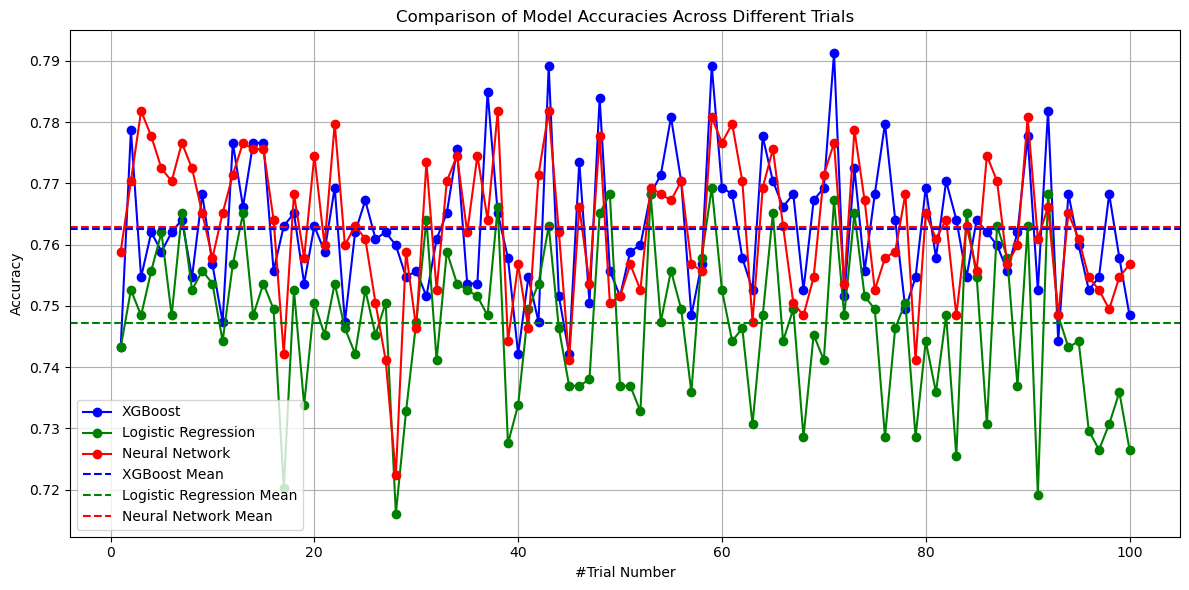

In [133]:
import matplotlib.pyplot as plt

# Assuming LIST is a list of lists, where each inner list has 3 accuracy values
# for XGBoost, Logistic Regression, and the Neural Network respectively.

# Convert LIST into a numpy array for easier indexing
import numpy as np
LIST = np.array(LIST)

# X values (trial numbers)
x_values = range(1, 101)  # Assuming you've done this for 30 trials

# Plotting
plt.figure(figsize=(12, 6))

# Plotting each model's results
plt.plot(x_values, LIST[:, 0], marker='o', label='XGBoost', color='blue')
plt.plot(x_values, LIST[:, 1], marker='o', label='Logistic Regression', color='green')
plt.plot(x_values, LIST[:, 2], marker='o', label='Neural Network', color='red')

# Drawing horizontal lines for means
plt.axhline(y=np.mean(LIST[:, 0]), color='blue', linestyle='--', label='XGBoost Mean')
plt.axhline(y=np.mean(LIST[:, 1]), color='green', linestyle='--', label='Logistic Regression Mean')
plt.axhline(y=np.mean(LIST[:, 2]), color='red', linestyle='--', label='Neural Network Mean')

# Setting labels, title, and legend
plt.xlabel('#Trial Number')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies Across Different Trials')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [117]:
LIST

[[0.7432150313152401, 0.7432150313152401, 0.7620041753653445],
 [0.778705636743215, 0.7526096033402923, 0.7661795407098121],
 [0.7546972860125261, 0.7484342379958246, 0.7651356993736952],
 [0.7620041753653445, 0.755741127348643, 0.7776617954070981],
 [0.7588726513569938, 0.7620041753653445, 0.7630480167014614],
 [0.7620041753653445, 0.7484342379958246, 0.7609603340292276],
 [0.7640918580375783, 0.7651356993736952, 0.7703549060542797],
 [0.7546972860125261, 0.7526096033402923, 0.767223382045929],
 [0.7682672233820459, 0.755741127348643, 0.755741127348643],
 [0.7567849686847599, 0.7536534446764092, 0.7651356993736952]]

In [107]:
lapis[99]=[3,3,3]

In [108]:
print(lapis)

[[0, 0, 0], [0, 0, 0], [3, 3, 3], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]

In [104]:
print(lapis)

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]

In [91]:
lapis[1]=2

IndexError: list assignment index out of range

In [89]:
print(lapis)

[]


In [84]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [85]:
import xgboost as xgb



Accuracy: 0.76


In [86]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=9)

# Train the logistic regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.75


In [87]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# New Neural Network Model using Keras
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile with an optimizer that has a learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping to monitor the validation loss and stop when it starts increasing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with validation data and early stopping
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")



Epoch 1/50
120/120 [==============================] - 1s 4ms/step - loss: 1.1735 - accuracy: 0.6651 - val_loss: 0.7662 - val_accuracy: 0.7098
Epoch 2/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6987 - accuracy: 0.7285 - val_loss: 0.6296 - val_accuracy: 0.7495
Epoch 3/50
120/120 [==============================] - 0s 2ms/step - loss: 0.6175 - accuracy: 0.7455 - val_loss: 0.5966 - val_accuracy: 0.7484
Epoch 4/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5890 - accuracy: 0.7494 - val_loss: 0.5736 - val_accuracy: 0.7568
Epoch 5/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5810 - accuracy: 0.7604 - val_loss: 0.5769 - val_accuracy: 0.7495
Epoch 6/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5701 - accuracy: 0.7549 - val_loss: 0.5642 - val_accuracy: 0.7495
Epoch 7/50
120/120 [==============================] - 0s 2ms/step - loss: 0.5637 - accuracy: 0.7604 - val_loss: 0.5606 - val_accuracy: 0.7526
Epoch 

In [41]:
len(y_test)

958

In [44]:
# Get feature names
feature_names = X.columns

# Get the coefficients
coefficients = model.coef_[0]

# Combine feature names and coefficients into a DataFrame
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Calculate absolute values of coefficients for ranking
coef_df['abs_coef'] = abs(coef_df['Coefficient'])

# Sort the DataFrame by absolute value of coefficient (from high to low)
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

# Print the DataFrame
print(coef_df)


                                                Feature  Coefficient  abs_coef
44                                        causabas_C349     7.607387  7.607387
84                                        causabas_C780     4.449993  4.449993
94                                        causabas_C80      3.384850  3.384850
39                                        causabas_C340     3.060758  3.060758
43                                        causabas_C348     2.992638  2.992638
93                                         causabas_C80     2.913806  2.913806
168                                        causabas_R99     2.861369  2.861369
169                                       causabas_R99      2.679457  2.679457
167                                       causabas_R98      2.637742  2.637742
73                                        causabas_C710     2.593886  2.593886
27                                        causabas_C169     2.485179  2.485179
41                                        causabas_C

In [29]:
import numpy as np

# Get feature names
feature_names = X.columns

# Get the coefficients
coefficients = model.coef_[0]

# Calculate the odds ratios from the coefficients
odds_ratios = np.exp(coefficients)

# Combine feature names, coefficients and odds ratios into a DataFrame
coef_odds_df = pd.DataFrame({
    'Feature': feature_names, 
    'Coefficient': coefficients, 
    'Odds_Ratio': odds_ratios,
    'abs_coef': abs(coefficients),
    })

# Sort the DataFrame by absolute value of coefficient (from high to low)
coef_odds_df = coef_odds_df.sort_values(by='abs_coef', ascending=False)

# Use pandas option to display all rows
pd.set_option('display.max_rows', None)

# Print the DataFrame
print(coef_odds_df)


                                                Feature  Coefficient  \
44                                        causabas_C349     7.196246   
373            causabas_simaih_rec_agrup2_Outros Causas     3.723571   
43                                        causabas_C348     2.645174   
39                                        causabas_C340     2.597234   
107                                       causabas_D381     2.206963   
41                                        causabas_C342     2.055313   
84                                        causabas_C780     1.973333   
357                          causabas_simaih_rec_cancer     1.883739   
371                 causabas_simaih_rec_agrup_Outros CA     1.883739   
370             causabas_simaih_rec_agrup_Demais Causas     1.839832   
40                                        causabas_C341     1.737093   
368                 causabas_simaih_rec_sint e ach anor     1.631389   
360                causabas_simaih_rec_doenc do ap circ     1.48

In [60]:
df=coef_odds_df

In [61]:
# Filter features with positive coefficients
positive_coef = df[df['Coefficient'] > 0]
positive_coef_sorted = positive_coef.sort_values(by='abs_coef', ascending=False)

# Filter features with negative coefficients
negative_coef = df[df['Coefficient'] < 0]
negative_coef_sorted = negative_coef.sort_values(by='abs_coef', ascending=False)

# Print features with positive coefficients
print("Features with positive coefficients:")
print(positive_coef_sorted)

# Print features with negative coefficients
print("Features with negative coefficients:")
print(negative_coef_sorted)



Features with positive coefficients:
                                              Feature  Coefficient  \
68                                    time_diag_Antes     0.740617   
73                               macro_pcn_Centro Sul     0.719079   
67                            perfil_rec_Radioterapia     0.669717   
44                                   cid_tto_min_C341     0.635375   
47                                   cid_tto_min_C348     0.560785   
35                                    cidpri_min_C343     0.526151   
17                                   racacor_indígena     0.476638   
32                                    cidpri_min_C340     0.458015   
79                                    macro_pcn_Norte     0.355486   
12  cir_proc_tto_min_rec_RESSECÇÃO DE TUMOR DO MED...     0.351232   
1                                              qt_aih     0.345481   
9                cir_proc_tto_min_rec_LINFADENECTOMIA     0.344668   
21                                          estadio_1

In [62]:
# Save features with positive coefficients to a CSV file
positive_coef_sorted.to_csv('features_positive_coef.csv', index=False)

# Save features with negative coefficients to a CSV file
negative_coef_sorted.to_csv('features_negative_coef.csv', index=False)
